In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import joblib

# 1. Load and Clean Initial Data

In [33]:

df1 = pd.read_csv('Injury_Risk.csv')
df1.drop(['total_goals', 'total_assists', 'FIFA rating'], axis=1, inplace=True)
df1.rename(columns={'Team Name': 'Team_Name'}, inplace=True)

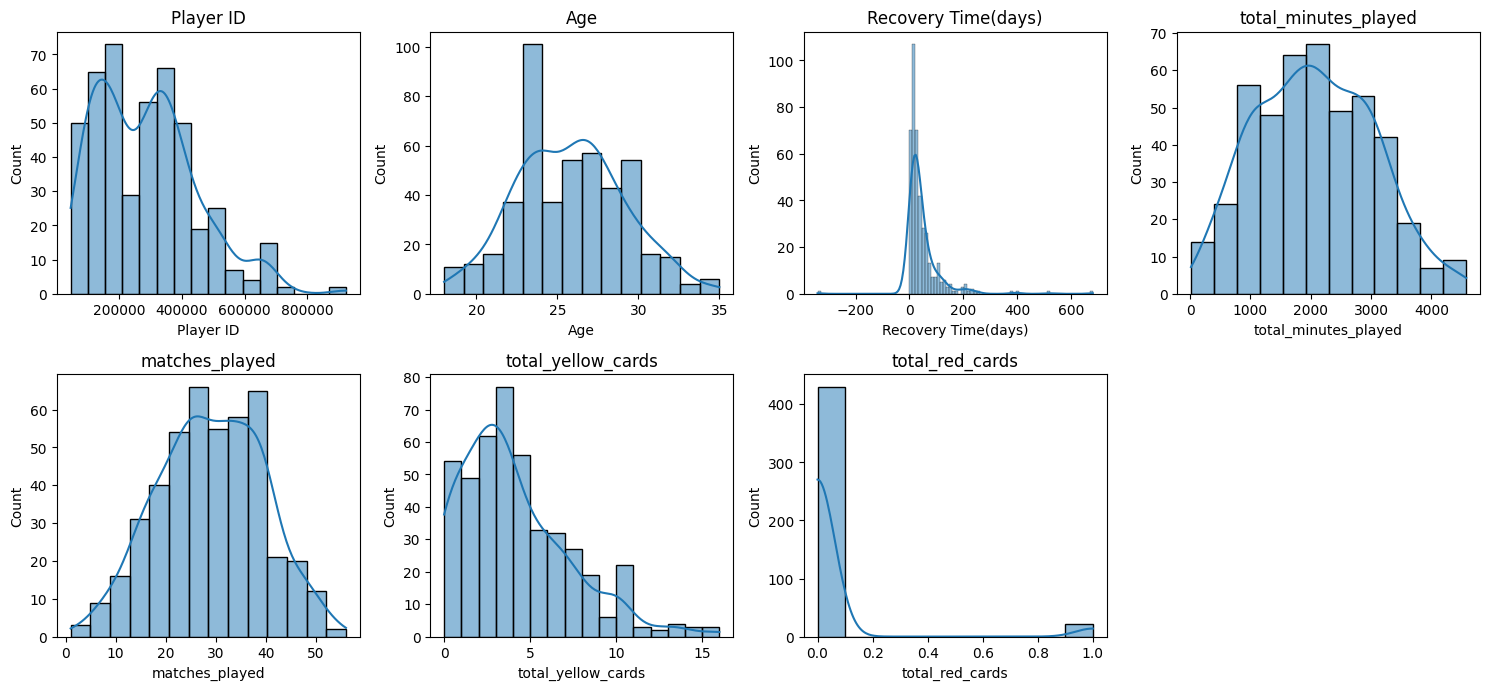

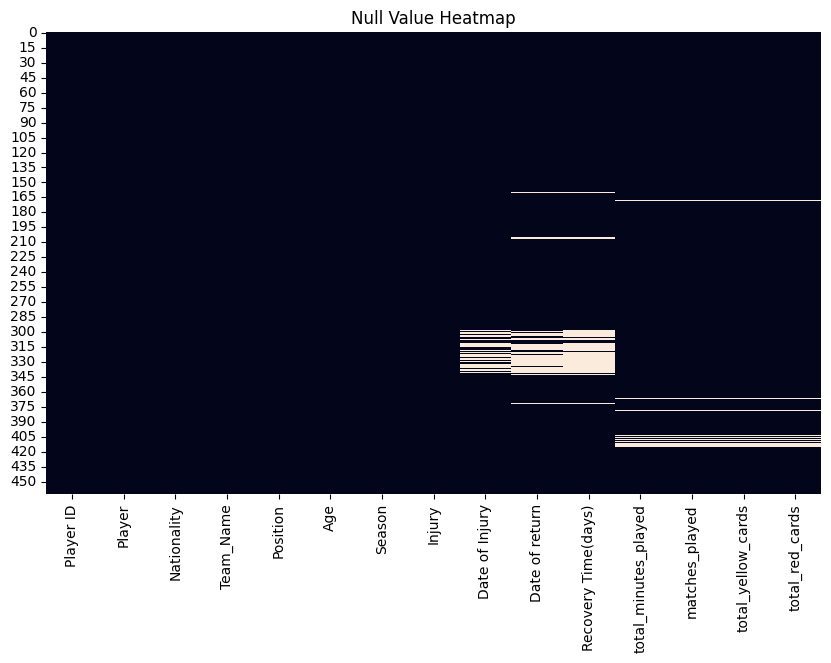

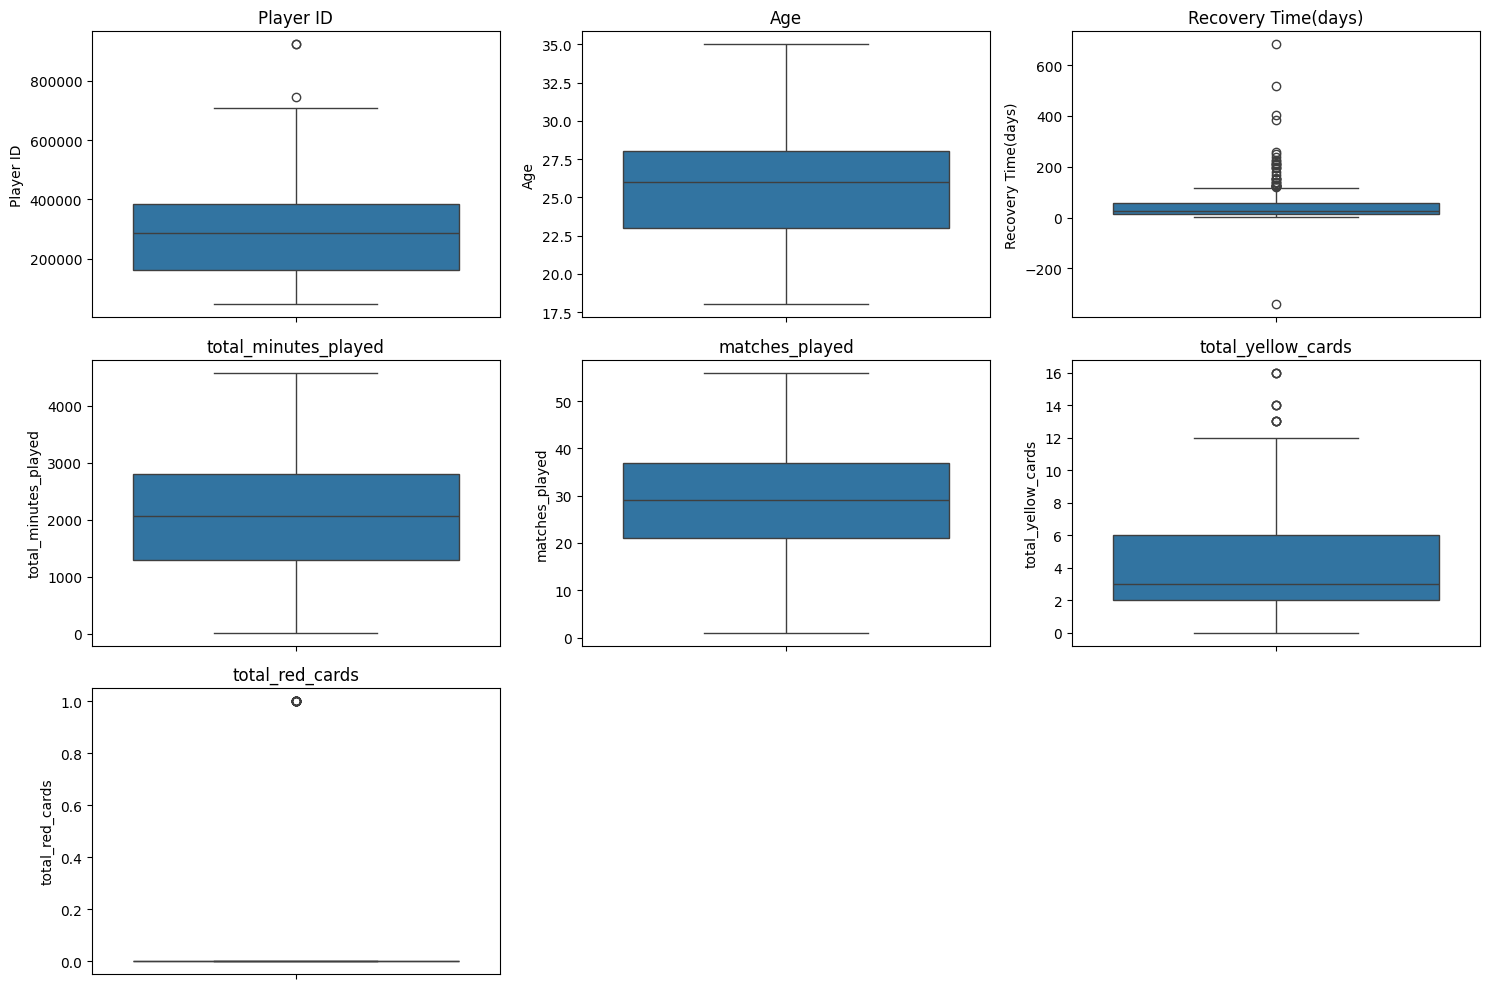

In [34]:
# 2. Visualizations
test = df1.drop(['fatigue_level'], axis=1)
numerical_cols = test.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df1[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(test.isnull(), cbar=False)
plt.title('Null Value Heatmap')
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=test[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Number of duplicate rows: 0


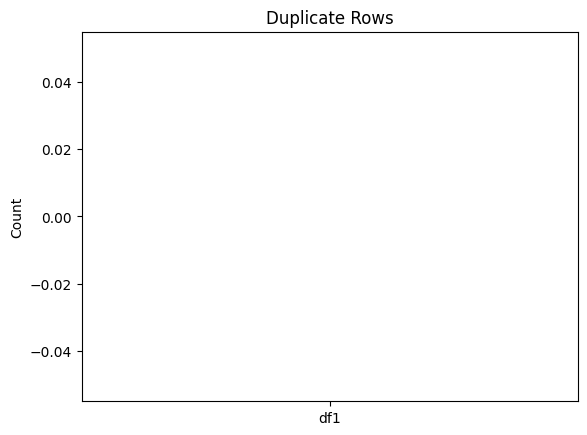

In [35]:
# Duplicates
duplicate_rows_df1 = df1[df1.duplicated()]
print("Number of duplicate rows:", len(duplicate_rows_df1))

plt.bar(['df1'], [len(duplicate_rows_df1)])
plt.title('Duplicate Rows')
plt.ylabel('Count')
plt.show()

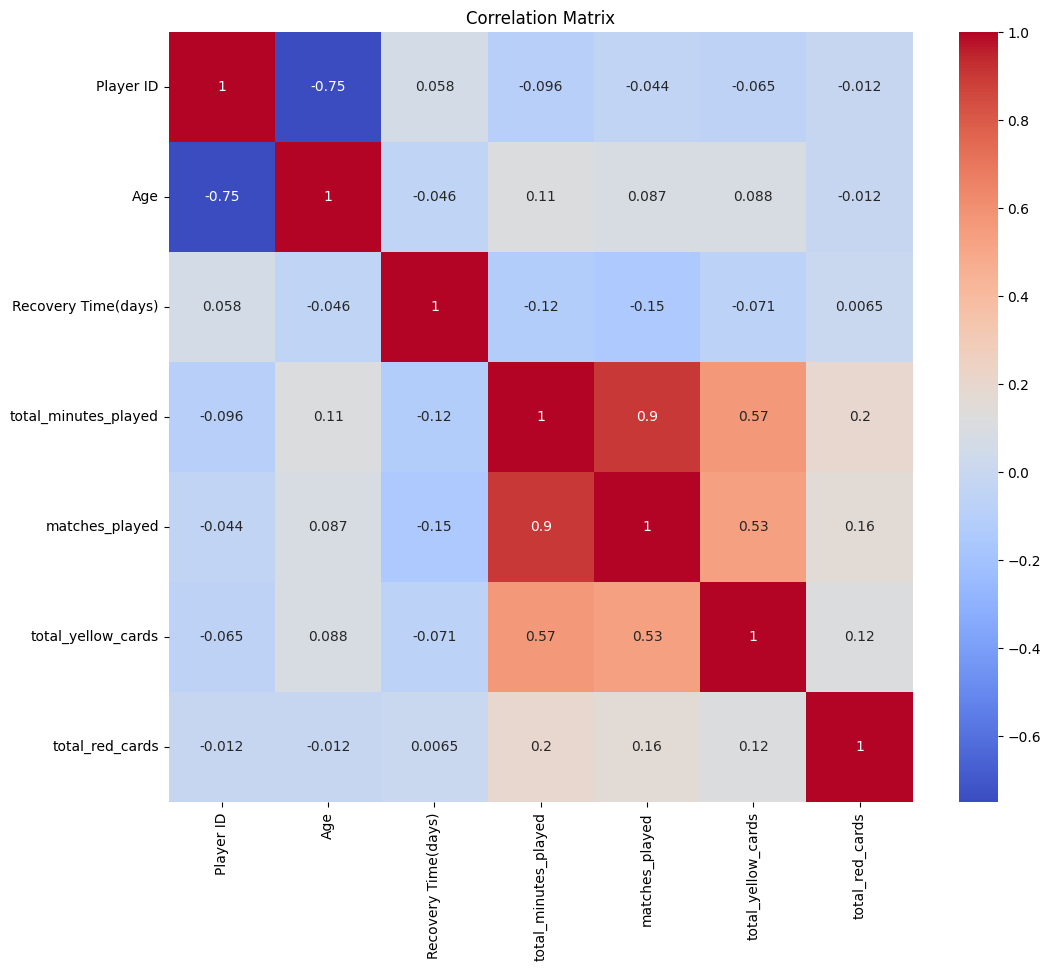

In [36]:
# Correlation heatmap
correlation_matrix = test[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

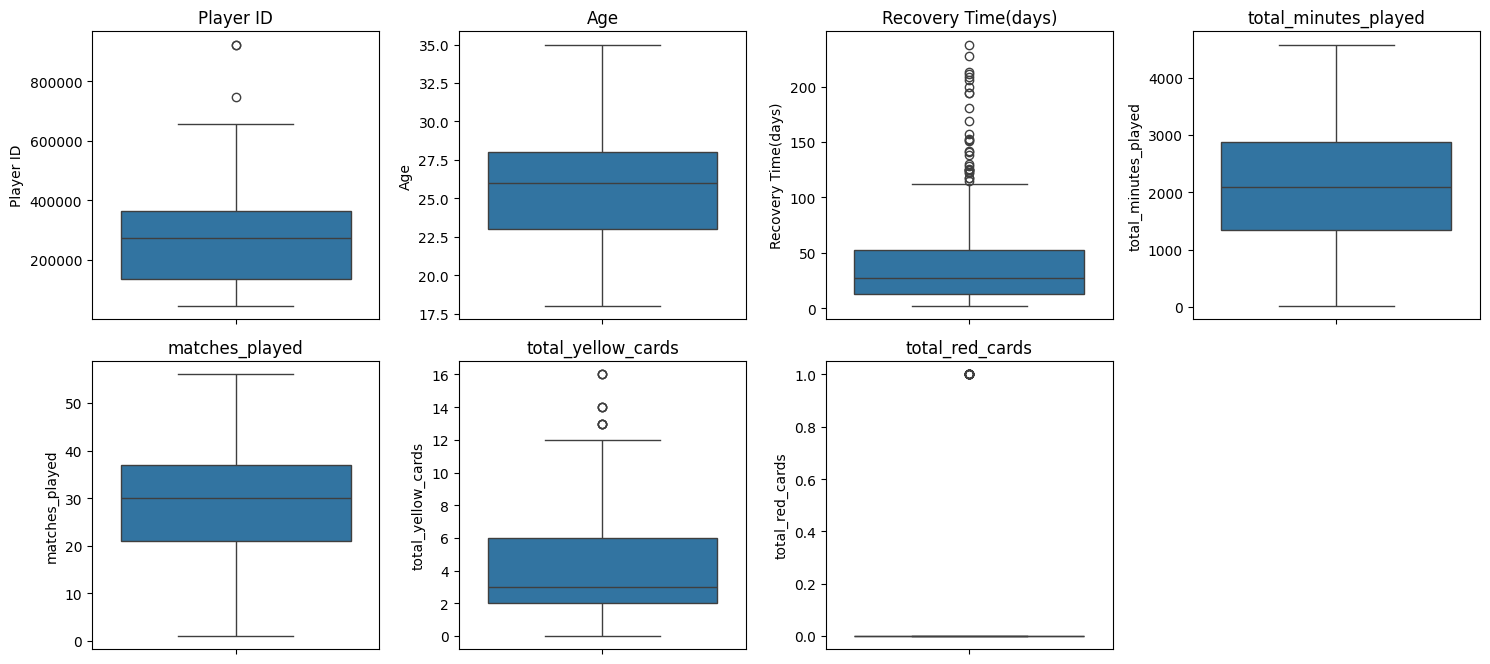

In [37]:
# 3. Data Cleaning
df2 = test.dropna()

# Remove outliers in Recovery Time
Q1 = df2['Recovery Time(days)'].quantile(0.25)
Q3 = df2['Recovery Time(days)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df2 = df2[(df2['Recovery Time(days)'] >= lower) & (df2['Recovery Time(days)'] <= upper * 2)]

# Visualize cleaned data
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df2[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [38]:
# 4. Encoding

# Clean injury labels
df2['Injury'] = df2['Injury'].str.strip().str.lower()

# Frequency encoding with integer ranking (not float percentages)
def frequency_rank_encoding(df, column_name, output_file):
    freq_rank = df[column_name].value_counts().rank(method='dense', ascending=False).astype(int)
    mapping_df = pd.DataFrame({'Value': freq_rank.index, 'Encoded': freq_rank.values})
    mapping_dict = dict(zip(freq_rank.index, freq_rank.values))
    df[column_name] = df[column_name].map(mapping_dict)
    mapping_df.to_csv(output_file, index=False)
    return mapping_dict

# Encode and save mappings
nationality_freq = frequency_rank_encoding(df2, 'Nationality', 'nationality_mapping.csv')
teamname_freq = frequency_rank_encoding(df2, 'Team_Name', 'teamname_mapping.csv')

# Label encode 'Position'
label_encoder_position = LabelEncoder()
df2['Position'] = label_encoder_position.fit_transform(df2['Position'])


In [39]:
# 5. Injury Group Mapping
injury_group_map = {
    # [Same dict as before... truncated for brevity]
    'achilles tendon irritation': 'Tendon',
    'virus': 'Head/Neck'
}
df2['Injury_Grouped'] = df2['Injury'].map(injury_group_map).fillna('Other')
df2['Injury_Grouped'] = df2['Injury_Grouped'].astype(str).str.strip()
label_encoder_injury = LabelEncoder()
df2['Injury_Grouped_Encoded'] = label_encoder_injury.fit_transform(df2['Injury_Grouped'])

# Save mapping
simplified_injury_mapping_df = pd.DataFrame({
    'Encoded Value': label_encoder_injury.transform(label_encoder_injury.classes_),
    'Injury Category': label_encoder_injury.classes_
})
simplified_injury_mapping_df.to_csv('simplified_injury_mapping.csv', index=False)
joblib.dump(label_encoder_injury, 'injury_label_encoder.pkl')


['injury_label_encoder.pkl']

In [40]:

# 6. Feature Engineering - Fatigue
season_length_weeks = 40
df2['fatigue_level'] = (df2['total_minutes_played'] / df2['matches_played']) * (df2['matches_played'] / season_length_weeks)
df2['fatigue_level'] = (df2['fatigue_level'] / df2['fatigue_level'].max()) * 100
df2['fatigue_level'] = df2['fatigue_level'].round(2)

# 7. Dates + Recovery Time
df2['Date of Injury'] = pd.to_datetime(df2['Date of Injury'], errors='coerce')
df2['Date of return'] = pd.to_datetime(df2['Date of return'], errors='coerce')
df2['Recovery Time(days)'] = (df2['Date of return'] - df2['Date of Injury']).dt.days
df2 = df2.dropna(subset=['Recovery Time(days)'])

# 8. Export Clean Data
df2.to_csv('Injury_Risk_Prep_Updated.csv', index=False)


In [41]:

from sklearn.preprocessing import StandardScaler
df3 = df2.copy()
numerical_cols = df3.select_dtypes(include=['number']).columns
cols_to_scale = [c for c in numerical_cols if c not in ['Player ID', 'Recovery Time(days)', 'Injury_Grouped_Encoded']]
scaler = StandardScaler()
df3[cols_to_scale] = scaler.fit_transform(df3[cols_to_scale])
df3.to_csv('Injury_Risk_Prep3.csv', index=False)

# Final preview
print(df2.head())


   Player ID            Player  Nationality  Team_Name  Position  Age  \
0     183318  Jamaal Lascelles            1          1         1   26   
1     135343      Fabian Schär            6          1         1   28   
2     135343      Fabian Schär            6          1         1   28   
3     135343      Fabian Schär            6          1         1   28   
4     170321      Paul Dummett           12          1         1   28   

    Season            Injury Date of Injury Date of return  \
0  2019/20       knee injury     2019-11-09     2020-01-13   
1  2019/20       knee injury     2019-10-20     2019-11-24   
2  2019/20  hamstring strain     2020-01-02     2020-01-17   
3  2019/20   shoulder injury     2020-07-16     2020-09-28   
4  2019/20      groin injury     2019-12-22     2020-01-10   

   Recovery Time(days)  total_minutes_played  matches_played  \
0                   65                2498.0            30.0   
1                   35                2712.0            32.0

In [42]:
print(nationality_freq)

{'England': 1, 'France': 2, 'Brazil': 3, 'Colombia': 4, 'Ireland': 5, 'Scotland': 5, 'Switzerland': 6, 'Iceland': 7, 'Ukraine': 8, 'Jamaica': 8, "Cote d'Ivoire": 8, 'Spain': 9, 'Uruguay': 10, 'Portugal': 11, 'Sweden': 11, 'Belgium': 11, 'DR Congo': 12, 'Netherlands': 12, 'Poland': 12, 'Denmark': 12, 'Nigeria': 12, 'Norway': 12, 'Wales': 12, 'Japan': 13, 'Bosnia-Herzegovina': 13, 'Germany': 13, 'Paraguay': 13, 'Mali': 13, 'Egypt': 14, 'Austria': 14, 'United States': 14, 'Czech Republic': 14, 'Serbia': 15, 'Italy': 15, 'Türkiye': 15, 'Argentina': 16, 'Burkina Faso': 16, 'Northern Ireland': 16, 'Cameroon': 16, 'South Africa': 16}
